# 회귀분석모형의 진단과 수정

회귀분석 결과의 진단(diagnosis)이란 회귀분석에 사용된 데이터가 회귀분석에 사용된 모형 가정을 제대로 만족하고 있는지를 확인하는 과정이다. 

## 잔차 정규성

데이터가 모형 가정을 만족하면 분석결과로 나온 잔차는 정규분포를 따라야 한다. 예를 들어 다음과 같이 2차 비선형 관계를 가지는 데이터를 선형 모형으로 회귀 분석한 경우를 살펴보자.

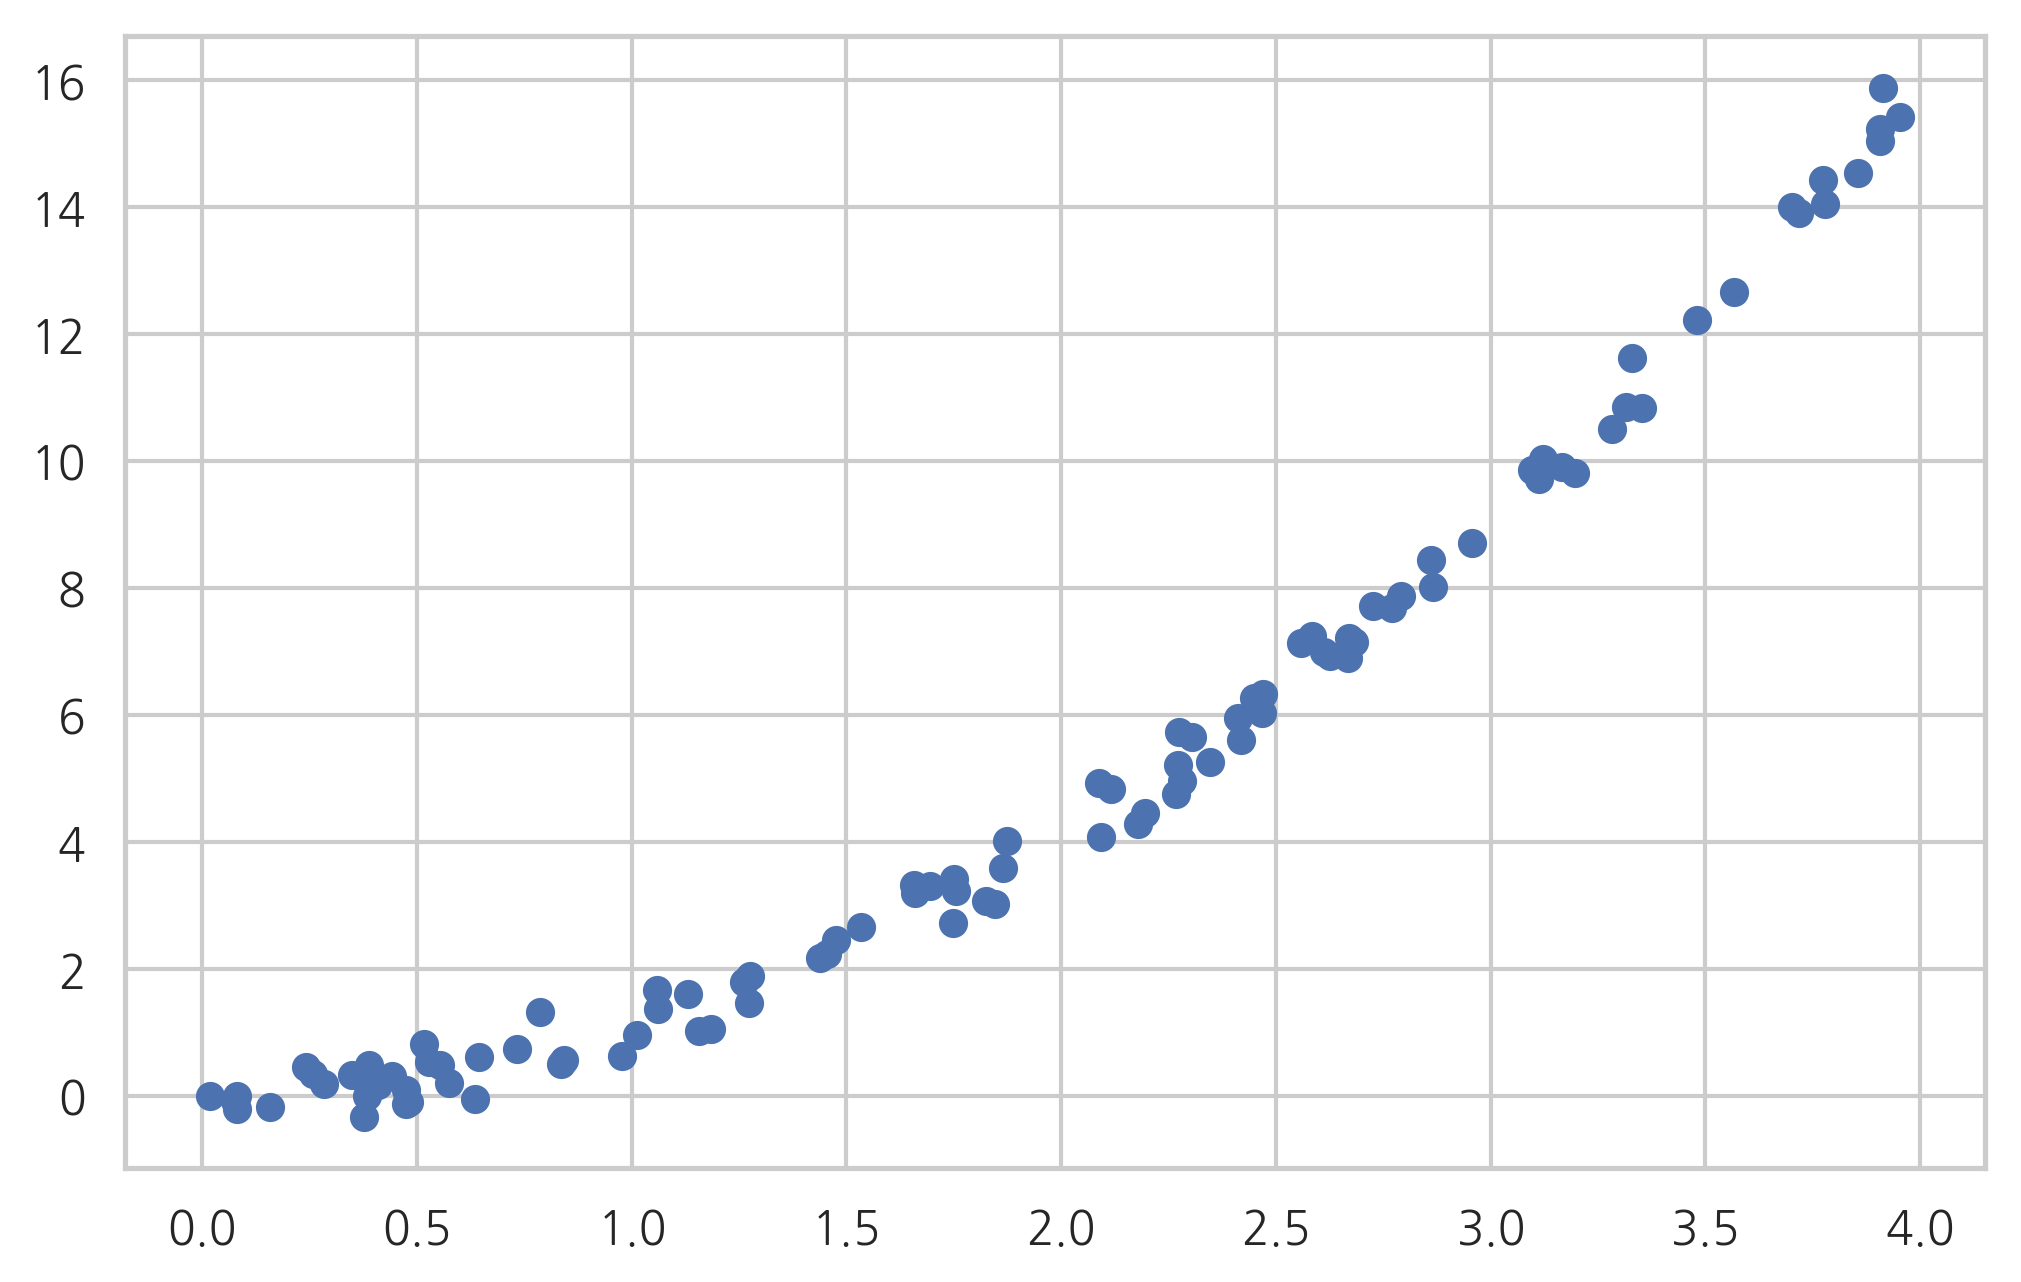

In [1]:
def make_regression2(n_sample=100, bias=0, noise=0.3, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 4
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y


x2, y2 = make_regression2()
plt.scatter(x2, y2)
plt.show()

In [2]:
dfX20 = pd.DataFrame(x2, columns=["X1"])
dfX2 = sm.add_constant(dfX20)
dfy2 = pd.DataFrame(y2, columns=["y"])

model2 = sm.OLS(dfy2, dfX2)
result2 = model2.fit()

QQ플롯과 정규성 검정에서 보듯이 잔차는 정규 분포를 따르지 않는다.

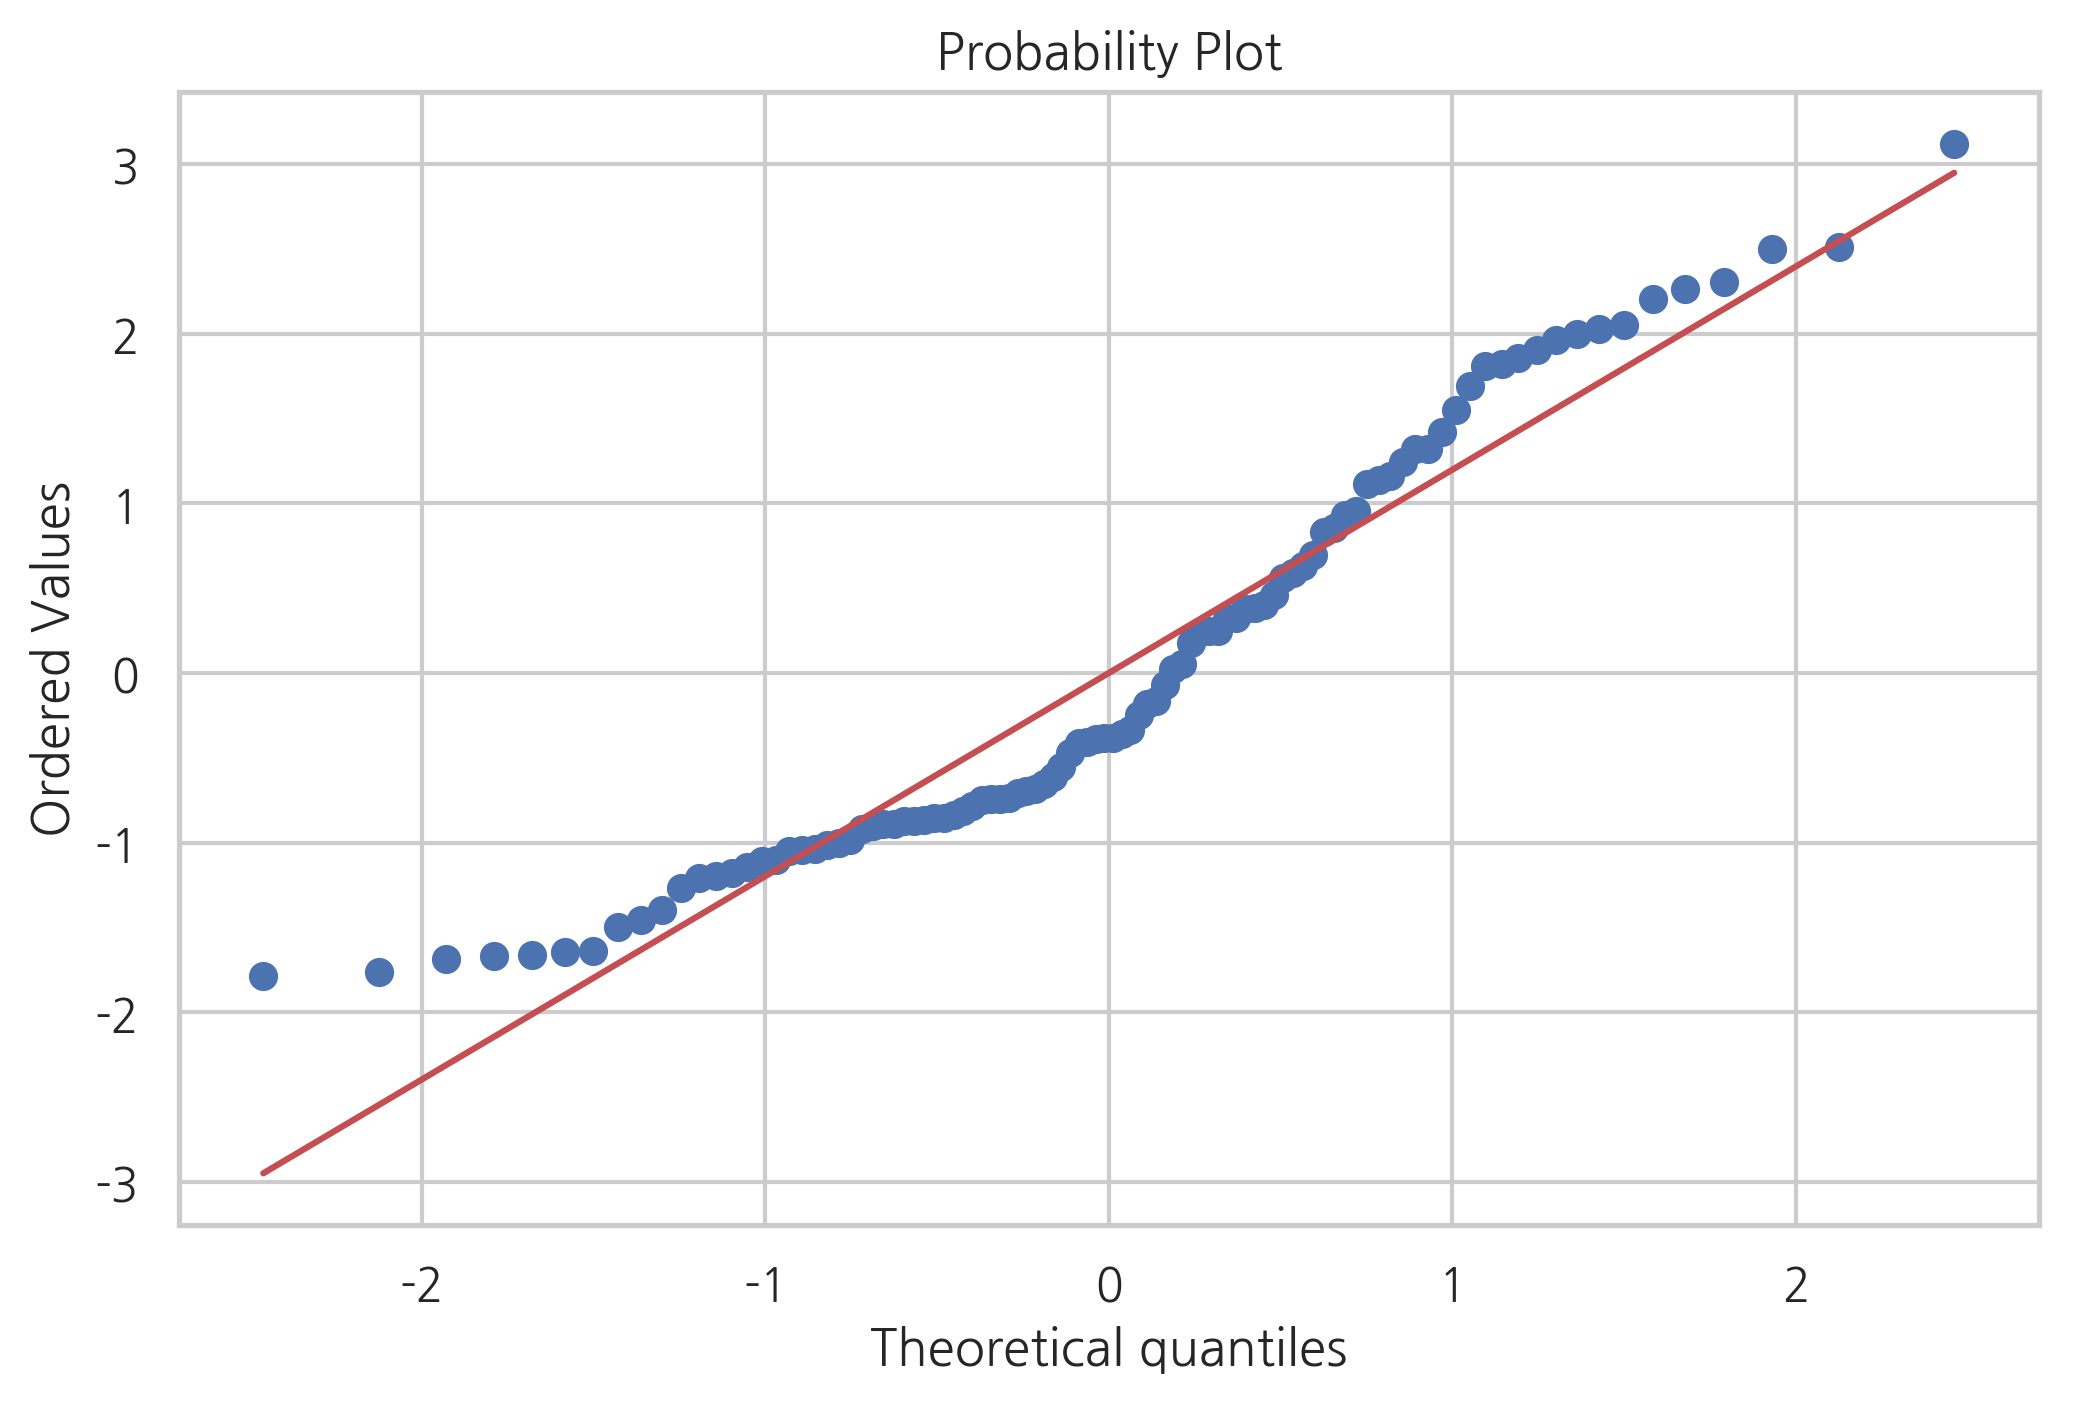

In [3]:
sp.stats.probplot(result2.resid, plot=plt)
plt.show()

In [4]:
test = sm.stats.omni_normtest(result2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  9.520
P-value     :  0.009


## 잔차와 독립 변수의 관계

이번에는 또다른 데이터를 살펴보자. 이 데이터도 2차 함수 관계를 따르고 있으므로 선형 모형을 따르지 않는다.

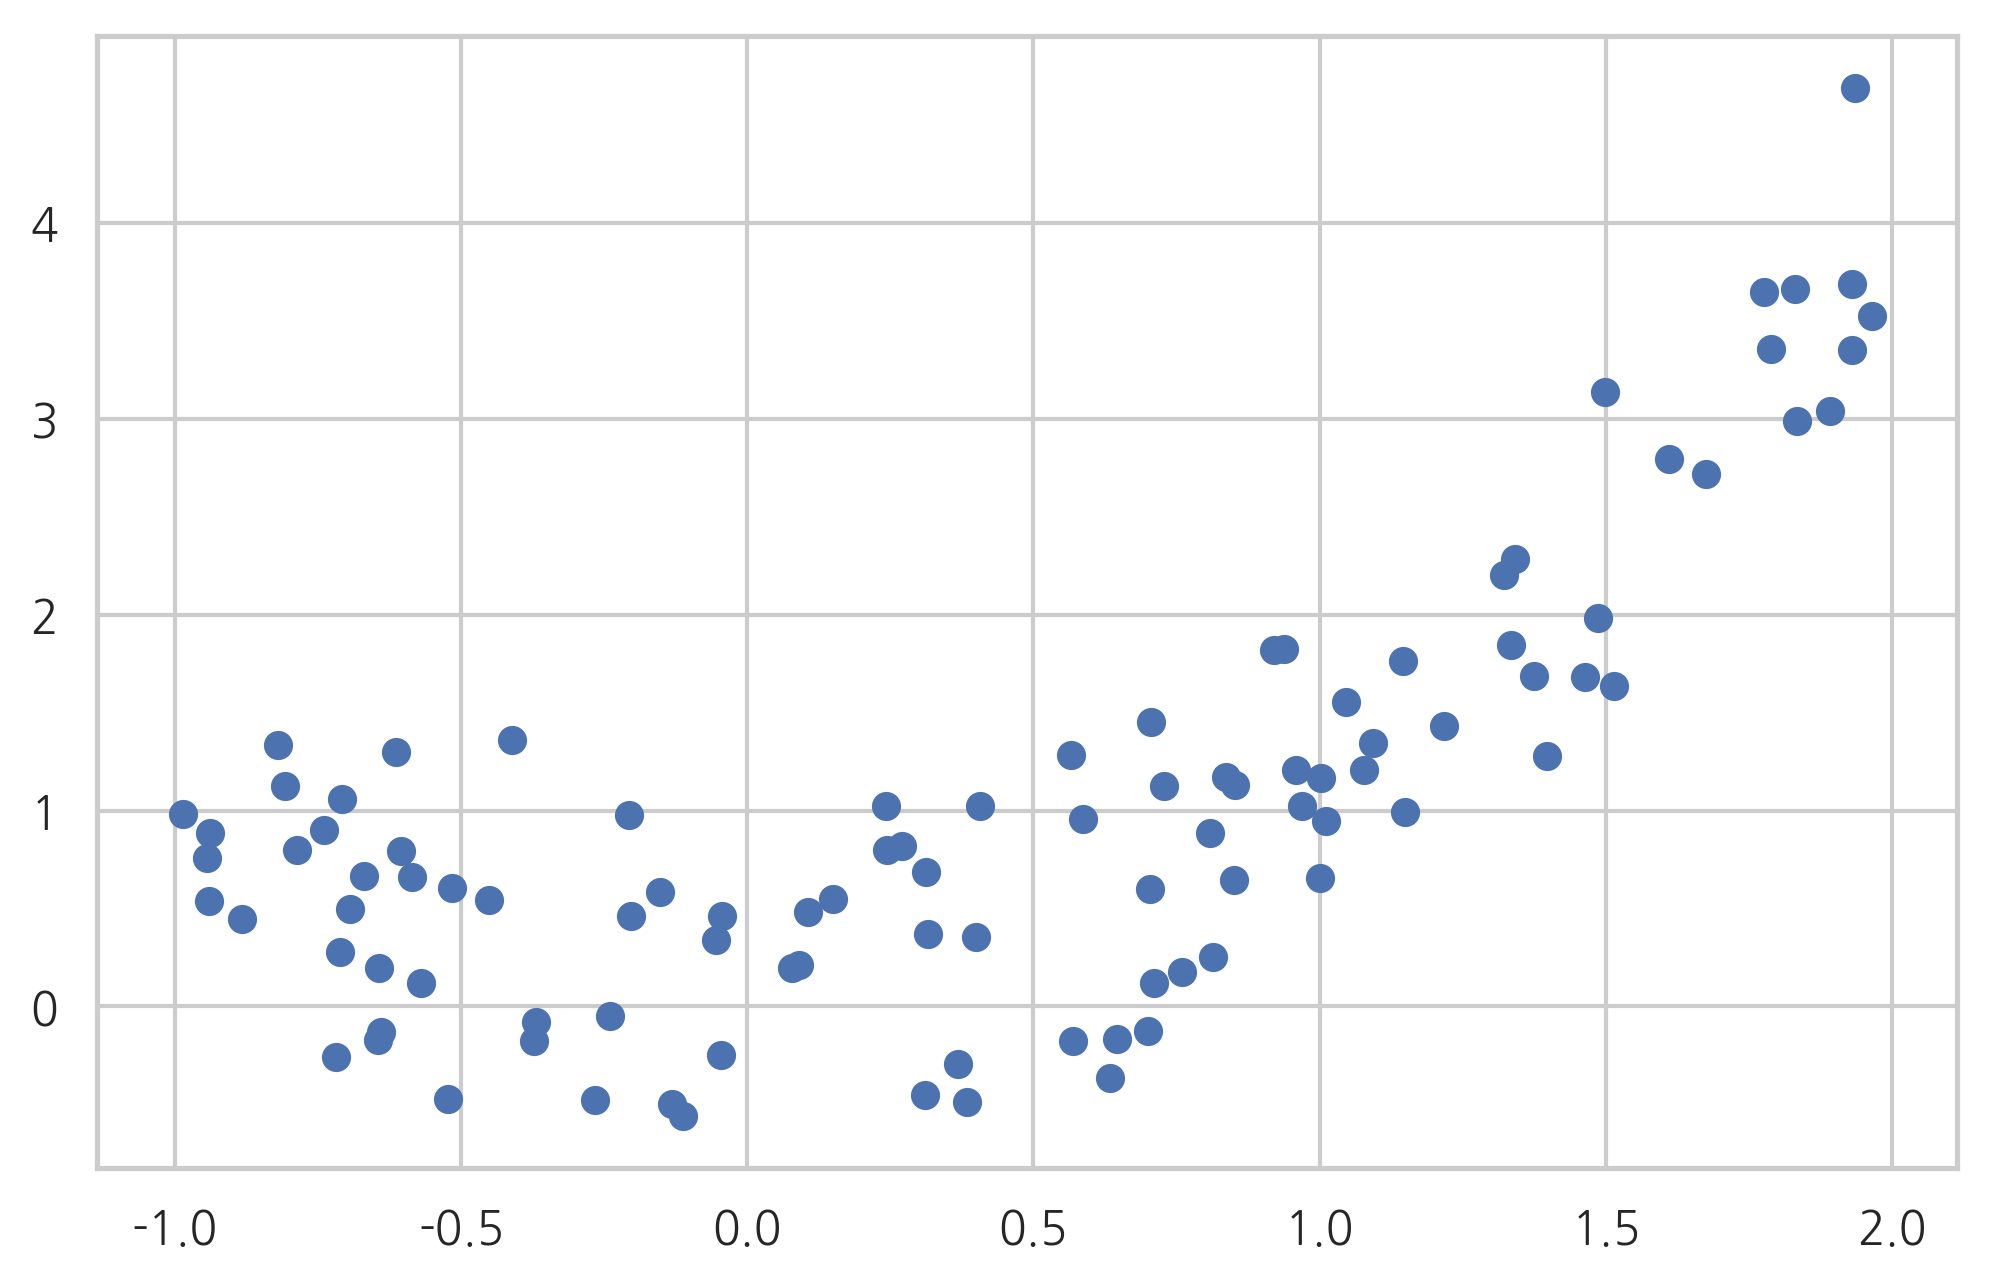

In [5]:
def make_regression3(n_sample=100, bias=0, noise=0.5, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 3 - 1
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y


x3, y3 = make_regression3()
plt.scatter(x3, y3)
plt.show()

In [6]:
dfX30 = pd.DataFrame(x3, columns=["X1"])
dfX3 = sm.add_constant(dfX30)
dfy3 = pd.DataFrame(y3, columns=["y"])

model3 = sm.OLS(dfy3, dfX3)
result3 = model3.fit()

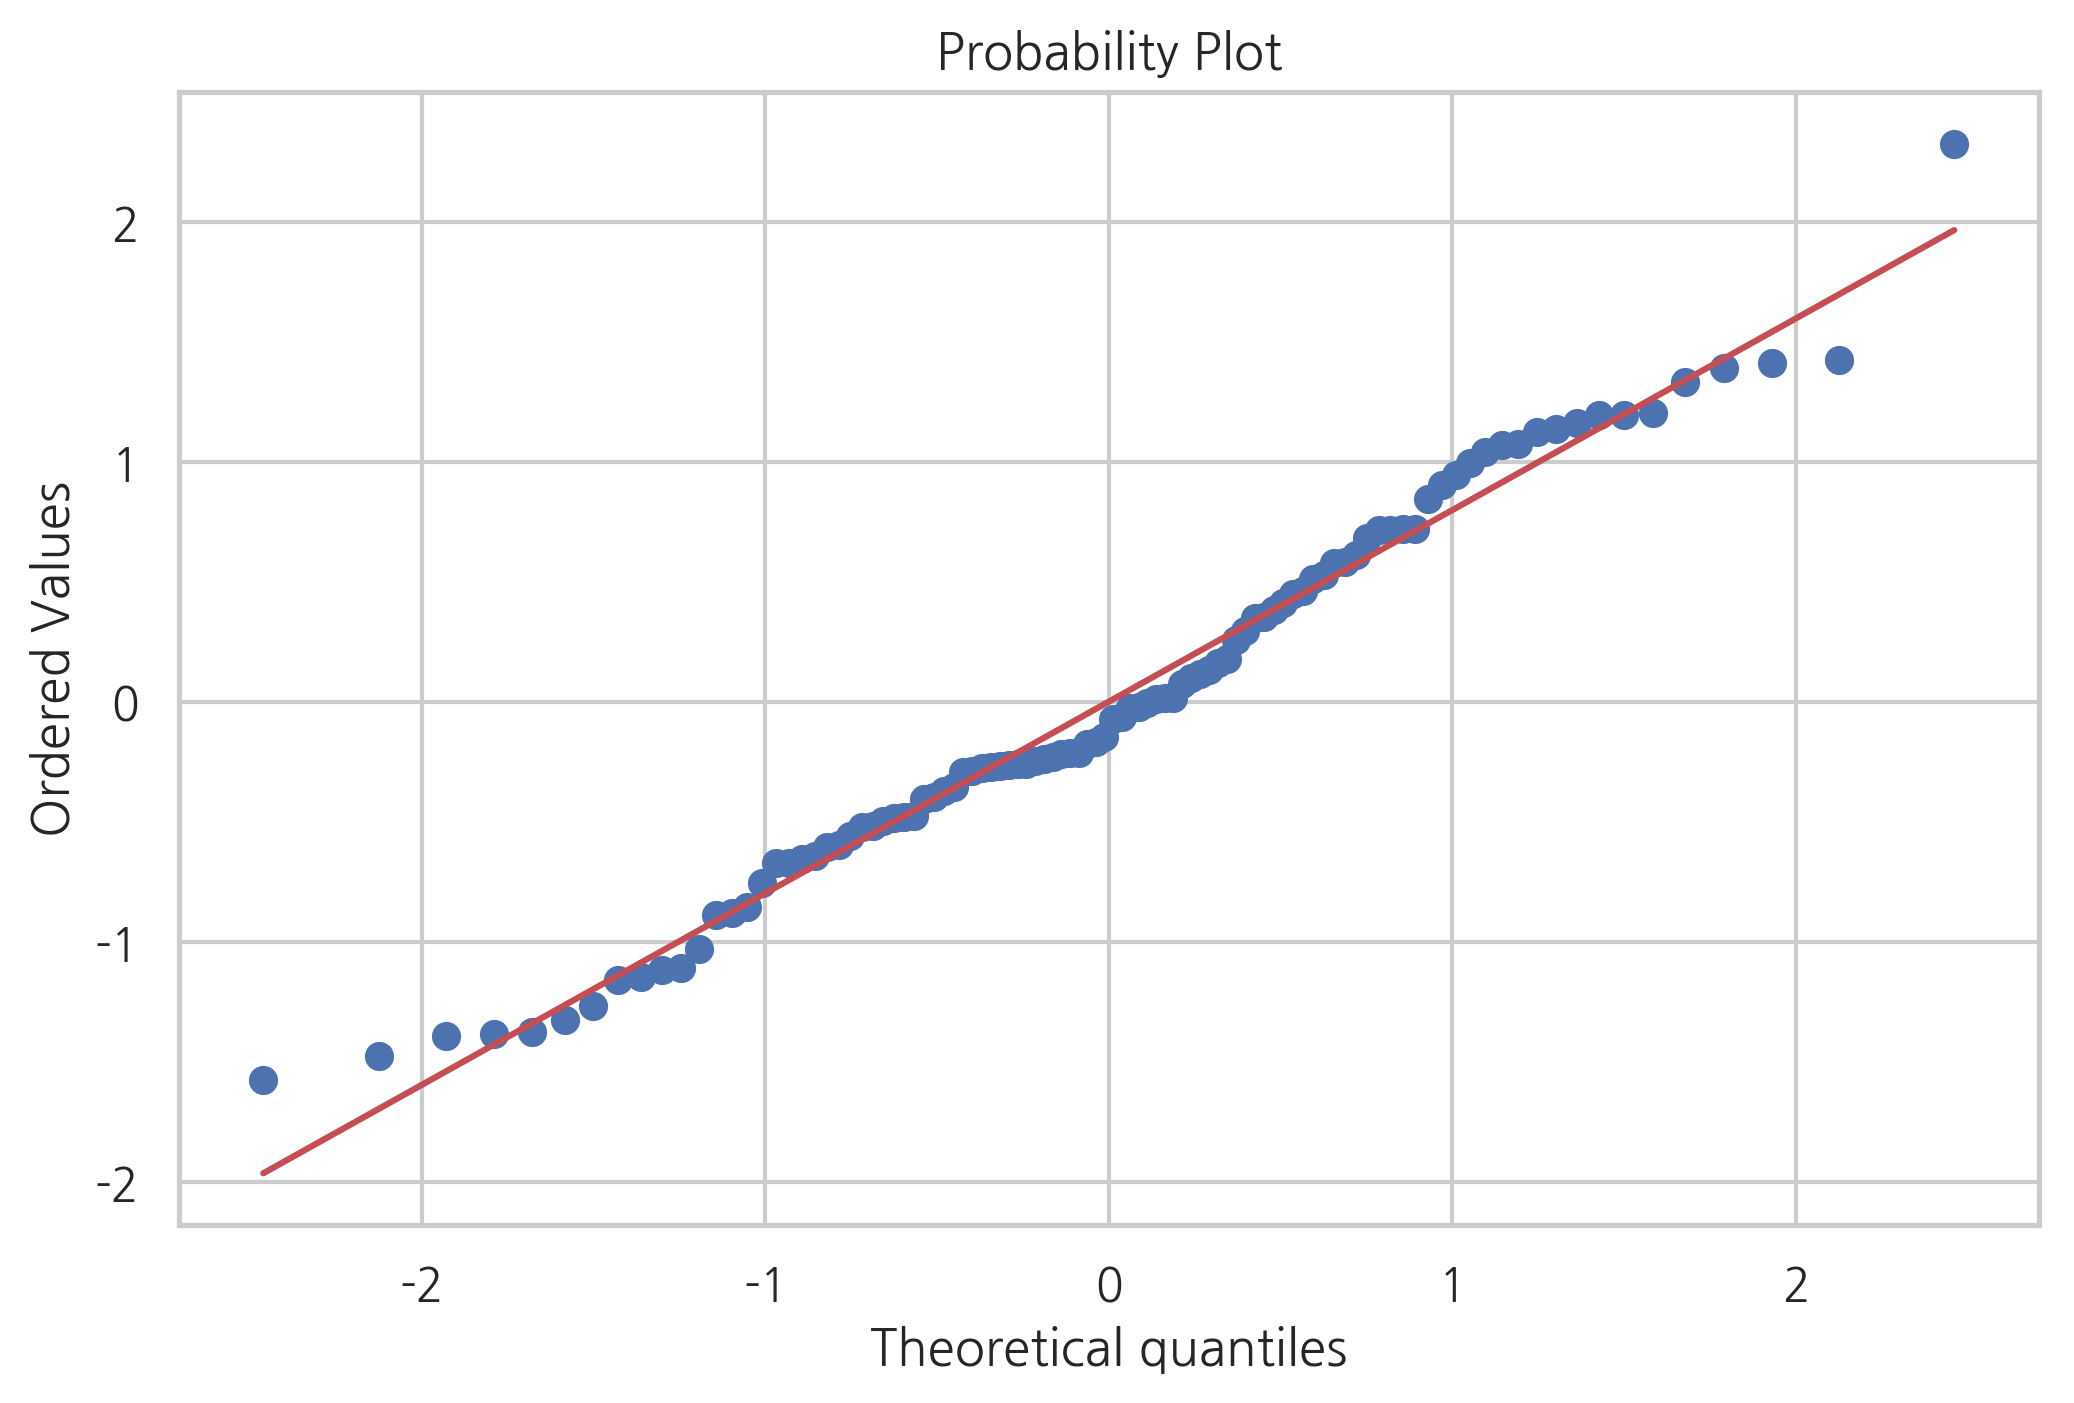

In [7]:
sp.stats.probplot(result3.resid, plot=plt)
plt.show()

In [8]:
test = sm.stats.omni_normtest(result3.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  1.202
P-value     :  0.548


데이터가 모형 가정을 따르지 않지만 잔차는 정규 분포를 따르는 것을 알 수 있다.

이러한 경우에는 잔차와 독립 변수간의 관계를 살펴보는 것이 도움이 될 수 있다. 데이터가 올바른 모형으로 분석되었다면 잔차는 더이상 독립 변수와 상관관계를 가지지 않아야 한다. 만약 잔차와 독립 변수간에 어떤 비선형 상관관계를 찾을 수 있다면 올바른 모형이 아니다.

다만 잔차와 특정 독립 변수간의 관계를 전체 모형이 올바른 모형이 아니라는 것을 알려줄 뿐이지 어떤 모형이 올바른 모형인지에 대한 정보는 주지 않는다.

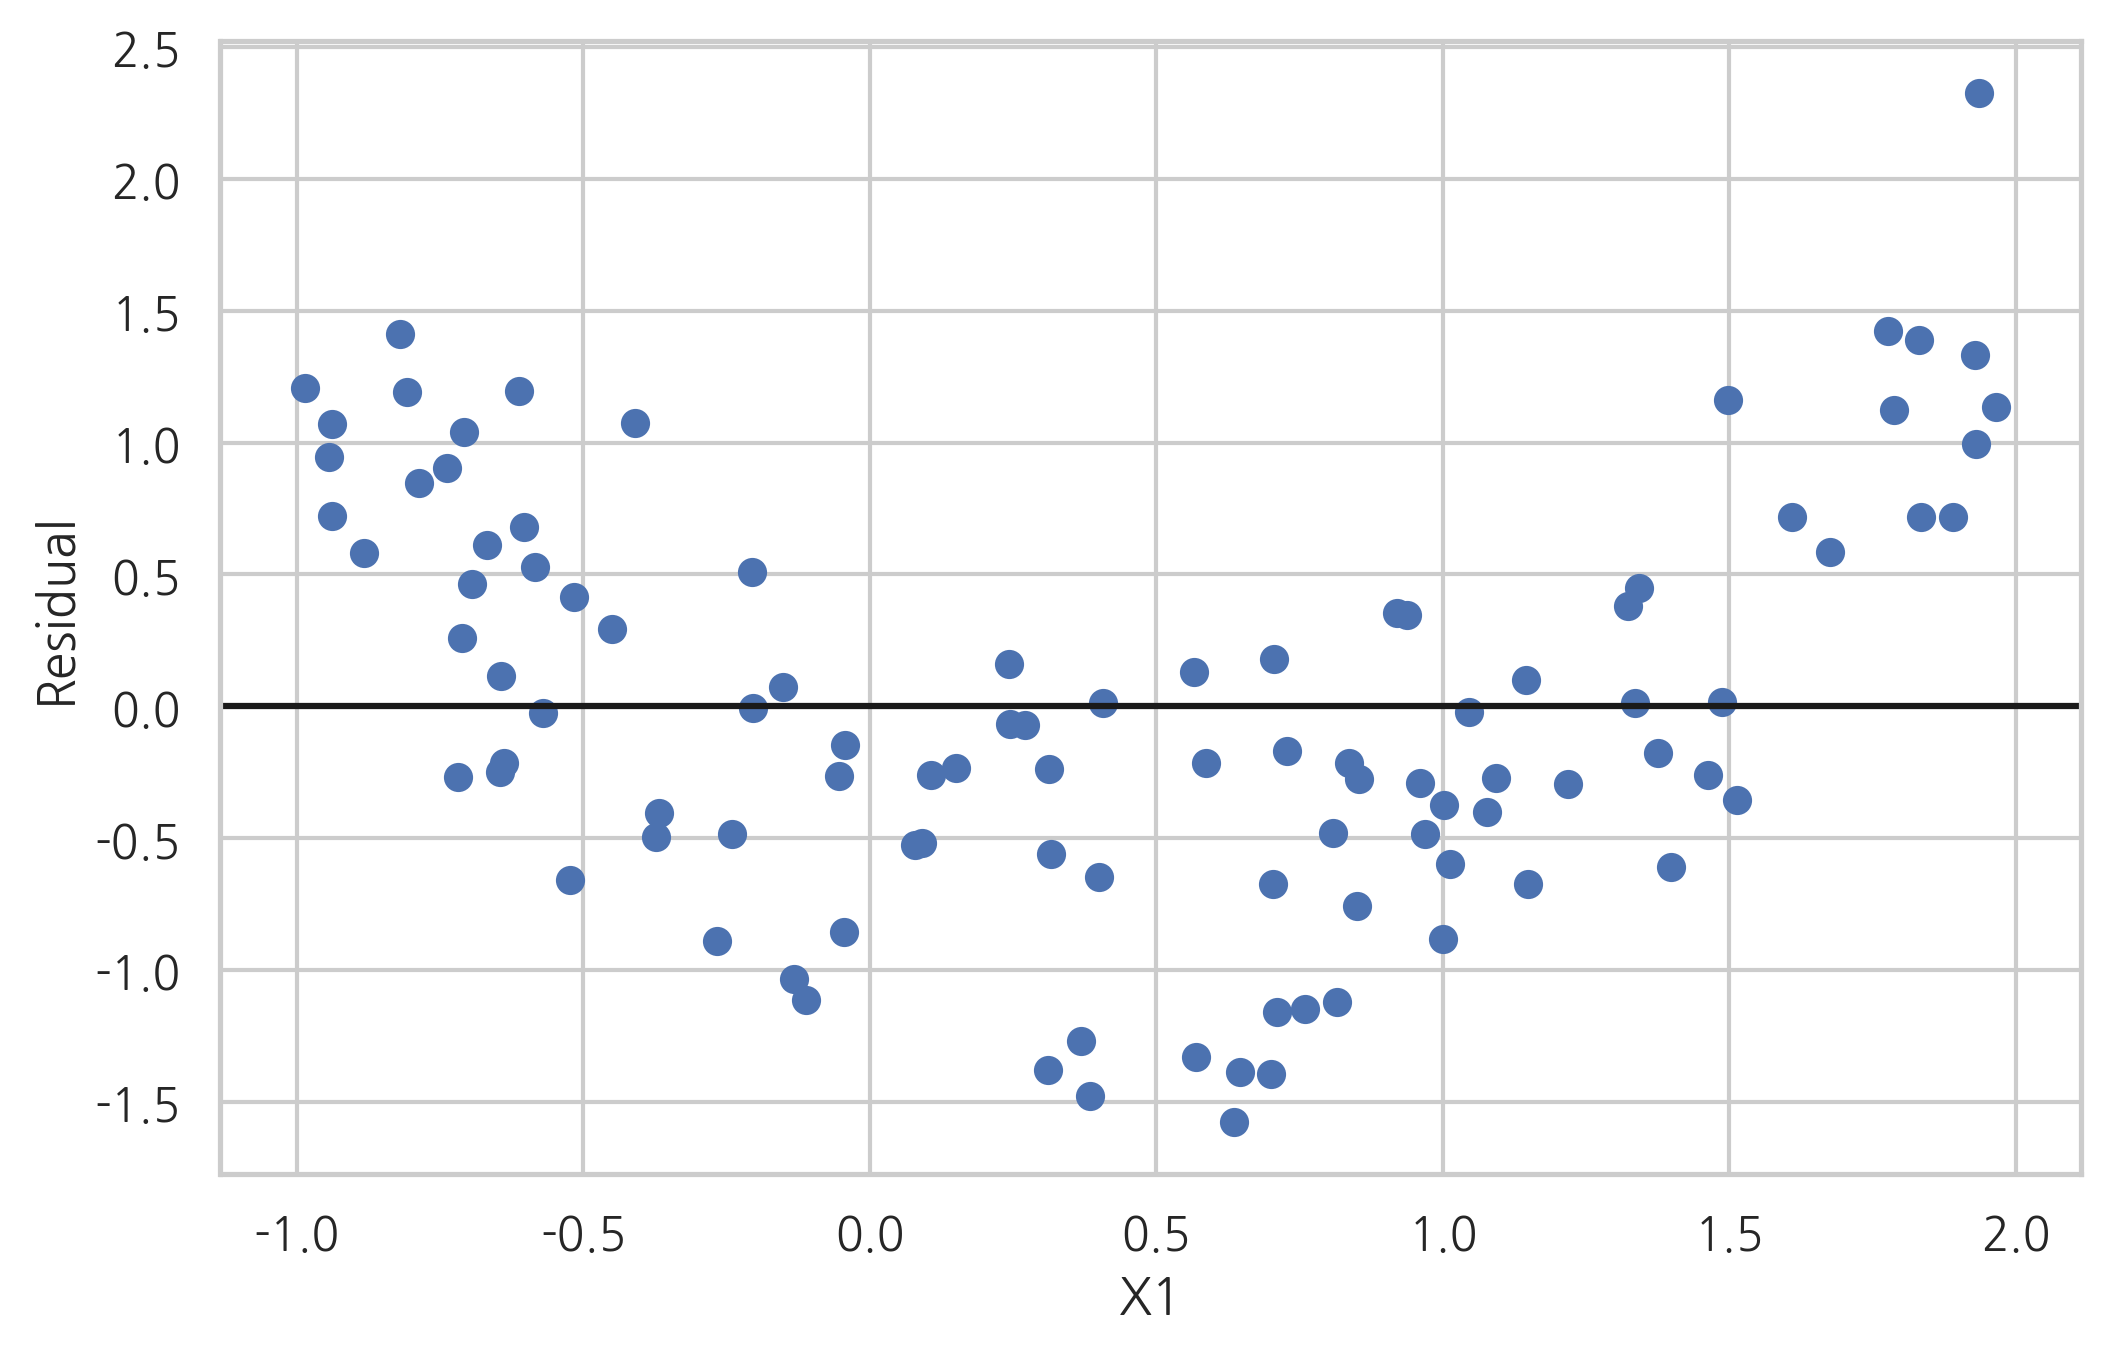

In [9]:
plt.plot(x3, result3.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

## 이분산성

선형 회귀 모형에서는 종속 변수 값의 분산이 독립 변수의 값과 상관없이 고정된 값을 가져야한다. 그러나 실제 데이터는 독립 변수 값의 크기가 커지면 종속 변수 값의 분산도 커지는 **이분산성**(heteroskedastic) 문제가 발생한다. 종속변수를 로그 변환한 트랜스로그(translog) 모형을 사용하면 이분산성 문제가 해결되는 경우도 있다.

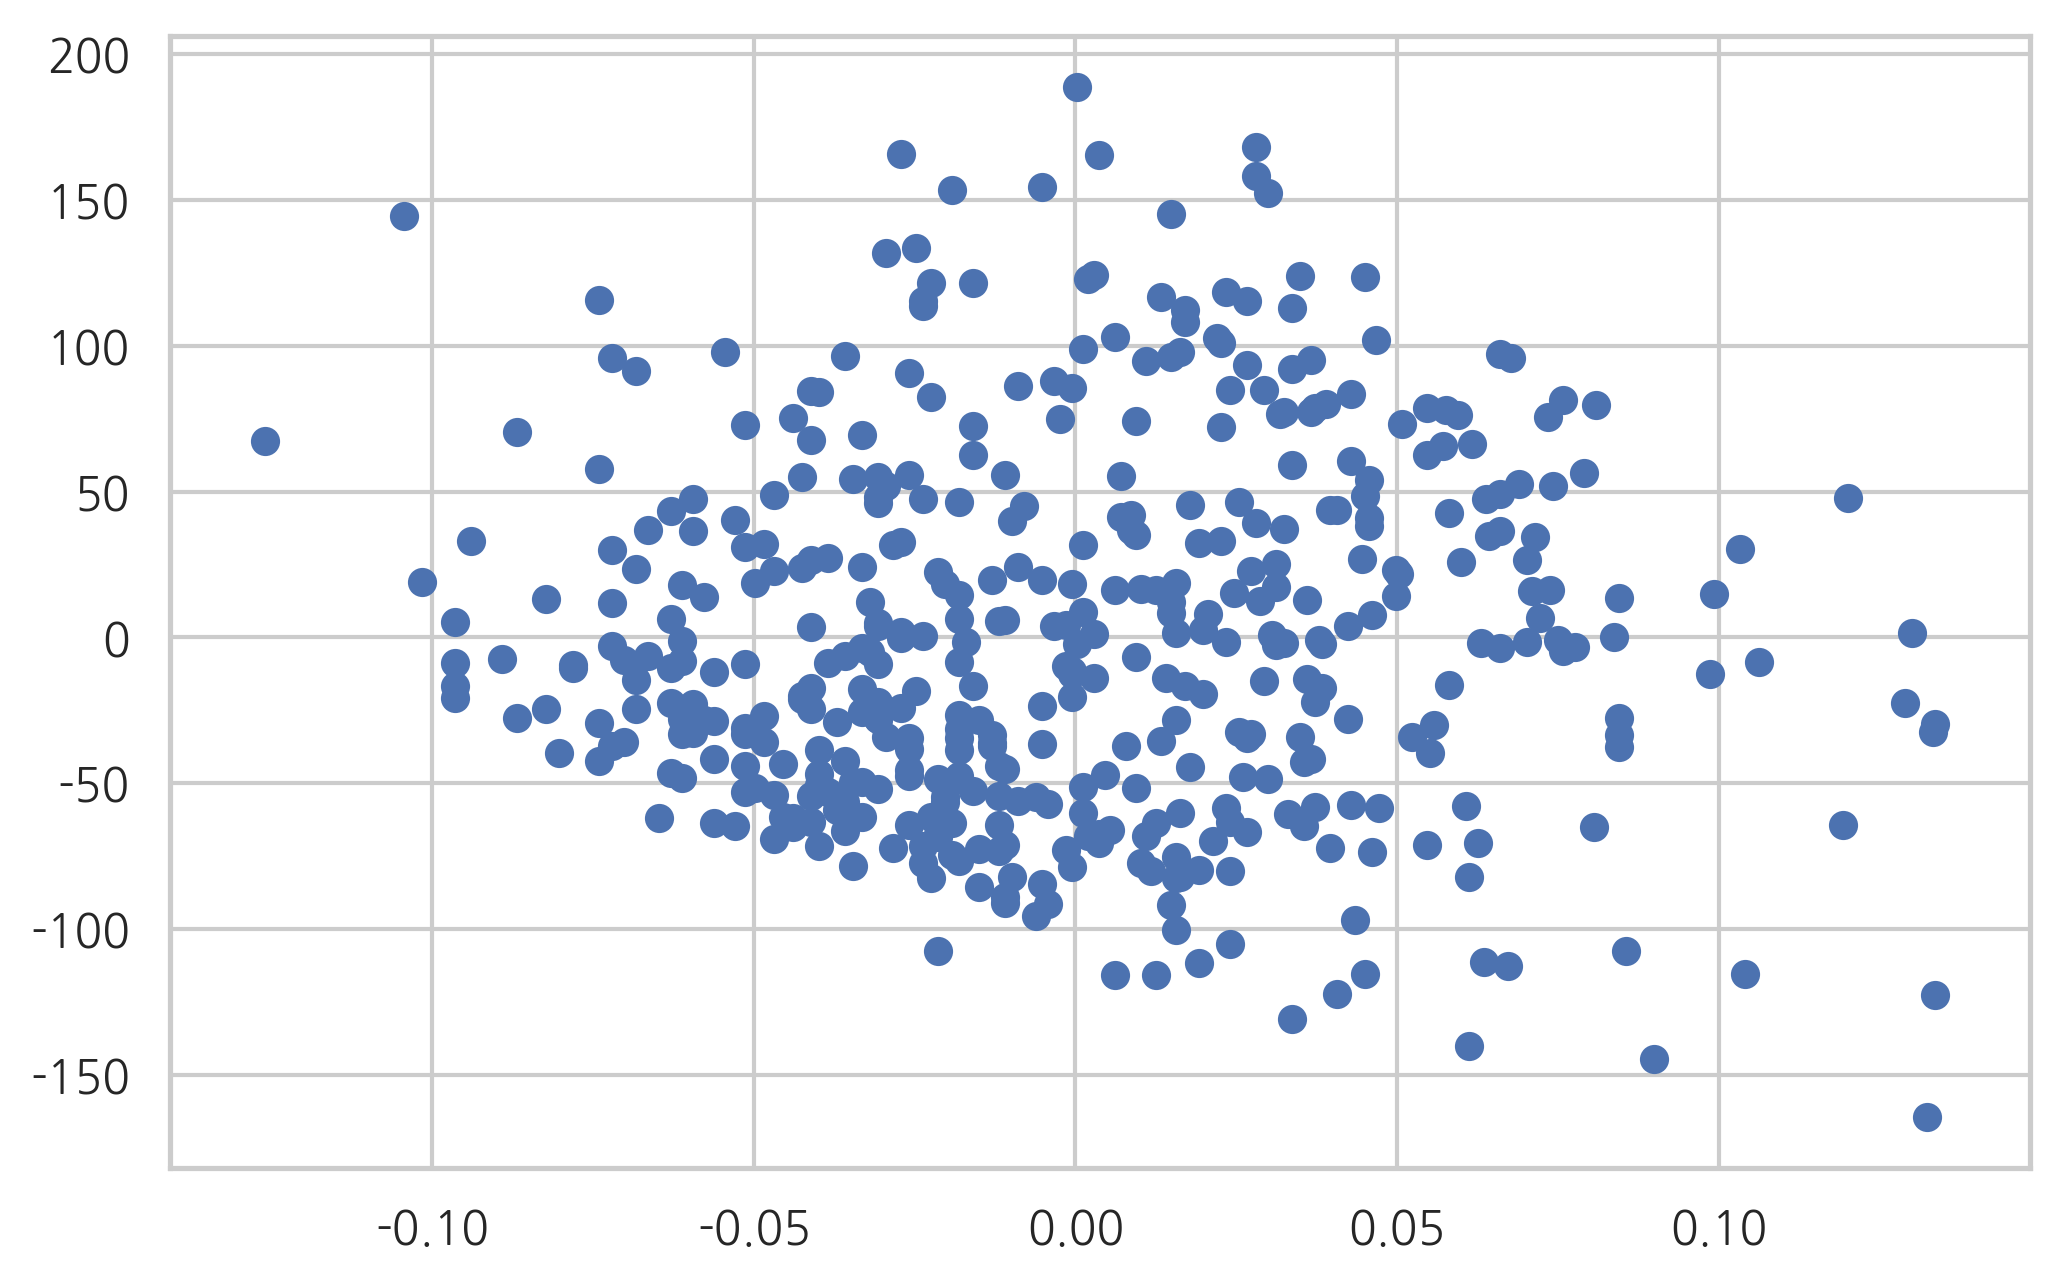

In [10]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
df = pd.concat([pd.DataFrame(diabetes.data, columns=["x%d" % (i + 1) for i in range(diabetes.data.shape[1])]),
                pd.DataFrame(diabetes.target, columns=["target"])],
               axis=1)
model = sm.OLS.from_formula("target ~ x9", data=df)
result = model.fit()
plt.scatter(df["x9"], result.resid)
plt.show()

## 자기 상관 계수

선형 회귀 모형에서는 오차(disturbance)들이 서로 (모수-조건부) 독립이라고 가정하고 있다. 따라서 잔차(residual)도 서로 독립이어야 한다. 만약 서로 독립이 아니라면 선형회귀 모형이 아닌 ARMA 모형 등의 시계열 모형을 사용해야 한다.

오차가 독립인지 검정하는 방법은 잔차를 시계열로 가정하여 자기상관계수를 구하는 것이다. 만약 독립이라면 시차(lag)가 0인 경우를 제외하고는 자기상관계수 $\rho_l$ 이 0이어야 한다. 이를 검사하는 검증으로는 다음과 같은 것들이 있다.

* Box-Pierce 검정
* Ljung-Box 검정
* Durbin-Watson 검정

이 검정들은 다음과 같은 귀무 가설을 검증한다.

$$
H_0: \rho_l = 0 \;\;\;\text{ for } i = 1, 2, \cdots, l
$$
